In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [3]:
img_size = (224, 224)
input_shape = img_size + (3,)
num_classes = 40
batch_size = 32

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='datasets/train',
  label_mode="categorical",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  directory='datasets/val',
  shuffle=False,
  label_mode="categorical",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  shuffle=False,
  directory='datasets/test',
  label_mode="categorical",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 2024 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


Found 2024 files belonging to 3 classes.


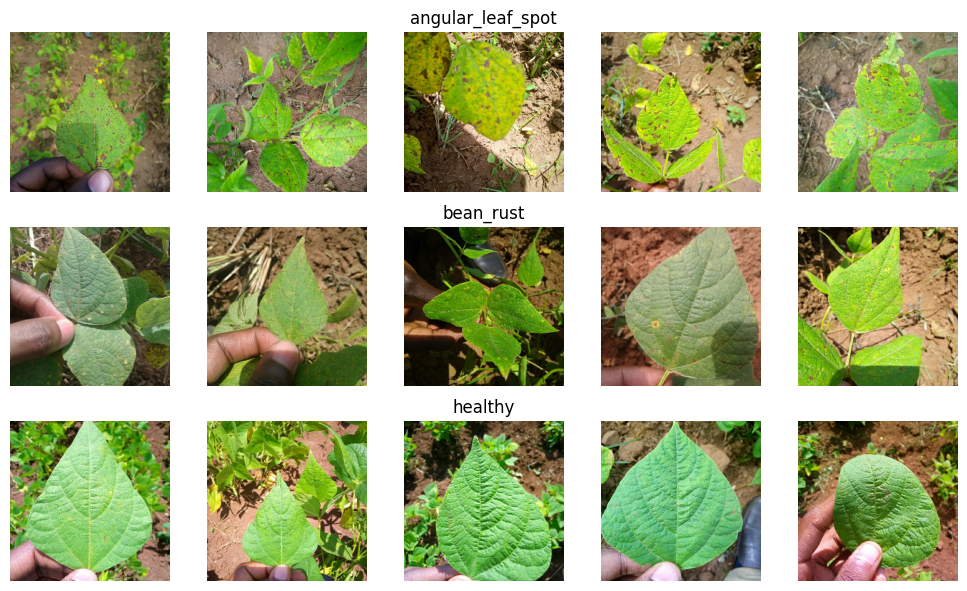

In [5]:
data_temp = tf.keras.utils.image_dataset_from_directory(
    directory='datasets/train',
    batch_size=5,
    shuffle=False,
    seed=123,
)

class_names = data_temp.class_names

fig, axes = plt.subplots(3, 5, figsize=(10,6))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    j = 0
    for img, label in data_temp:
        if label[0] == i:
            ax = axes[i*5 + j]
            ax.imshow(img[0].numpy().astype("uint8"))
            ax.axis('off')
            if j == 2:  # middle image
                ax.set_title(cls)  # set title for the middle image
            j += 1
            if j == 5:
                break

plt.tight_layout()
plt.show()

In [ ]:
# Sınıf dağılımlarını hesaplama
def get_class_distribution(dataset):
    class_counts = np.zeros(len(class_names))
    for images, labels in dataset:
        class_counts += np.sum(labels, axis=0)
    return class_counts

train_class_counts = get_class_distribution(train_ds)
val_class_counts = get_class_distribution(val_ds)
test_class_counts = get_class_distribution(test_ds)

# Dağılımları görselleştirme
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

axes[0].barh(class_names, train_class_counts)
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Number of Samples')

axes[1].barh(class_names, val_class_counts)
axes[1].set_title('Validation Set Class Distribution')
axes[1].set_xlabel('Number of Samples')

axes[2].barh(class_names, test_class_counts)
axes[2].set_title('Test Set Class Distribution')
axes[2].set_xlabel('Number of Samples')

plt.tight_layout()
plt.show()

In [6]:
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)
y_test_true = np.argmax(y_test_true, axis=-1)

In [7]:
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Lambda(preprocess_input)(inputs)

resnet_model = ResNet50(weights='imagenet', 
                        include_top=False, 
                        input_shape=input_shape,
                        input_tensor=x)

for layer in resnet_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(resnet_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=predictions)

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [9]:

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

In [10]:
history = model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[early_stopping])


Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 513ms/step - accuracy: 0.6910 - loss: 0.8019 - val_accuracy: 0.9323 - val_loss: 0.1455
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 483ms/step - accuracy: 0.9384 - loss: 0.1767 - val_accuracy: 0.9624 - val_loss: 0.1090
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.9609 - loss: 0.1200 - val_accuracy: 0.9549 - val_loss: 0.0957
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 507ms/step - accuracy: 0.9781 - loss: 0.0639 - val_accuracy: 0.9398 - val_loss: 0.1091
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 497ms/step - accuracy: 0.9817 - loss: 0.0564 - val_accuracy: 0.9699 - val_loss: 0.0948
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9821 - loss: 0.0486 - val_accuracy: 0.9474 - val_loss: 0.1147
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - accuracy: 0.9855 - loss: 0.0454 - val_accuracy: 0.9474 - val_loss: 0.1095
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - accuracy: 0.9888 - loss: 0.0402 - val_accuracy:

In [11]:
model.save('saved_model/my_model.h5')

In [12]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv("history/history_resnet.csv", index=False)

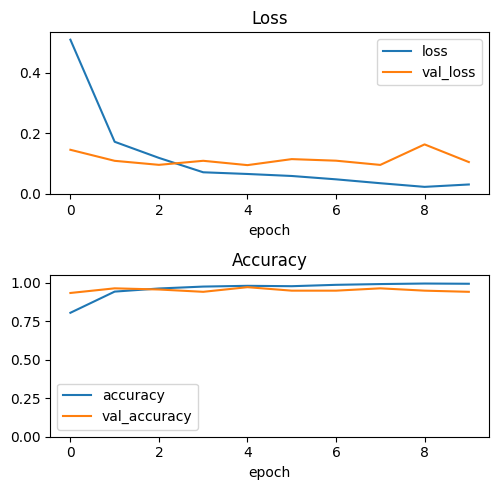

In [13]:
history_df = pd.read_csv("history/history_resnet.csv")

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(211)
ax1.set_title('Loss')
ax1.plot(history_df['loss'], label='loss')
ax1.plot(history_df['val_loss'], label='val_loss')
ax1.set_xlabel("epoch")
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.set_title('Accuracy')
ax2.plot(history_df['accuracy'], label='accuracy')
ax2.plot(history_df['val_accuracy'], label='val_accuracy')
ax2.set_xlabel("epoch")
ax2.legend()
ax2.set_ylim(0, 1.05) 

plt.tight_layout()
plt.show()

In [14]:
# Make predictions on the test dataset
y_test_pred = model.predict(test_ds)
y_test_pred_classes = np.argmax(y_test_pred, axis=-1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step


<Figure size 800x800 with 0 Axes>

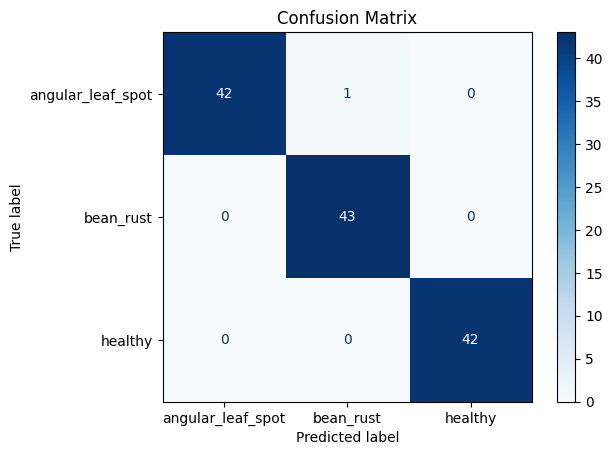

                   precision    recall  f1-score   support

angular_leaf_spot       1.00      0.98      0.99        43
        bean_rust       0.98      1.00      0.99        43
          healthy       1.00      1.00      1.00        42

         accuracy                           0.99       128
        macro avg       0.99      0.99      0.99       128
     weighted avg       0.99      0.99      0.99       128



In [16]:


# Confusion matrix oluşturma
cm = confusion_matrix(y_test_true, y_test_pred_classes)

# Confusion matrix'i görselleştirme
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Sınıflandırma raporu
print(classification_report(y_test_true, y_test_pred_classes, target_names=class_names))


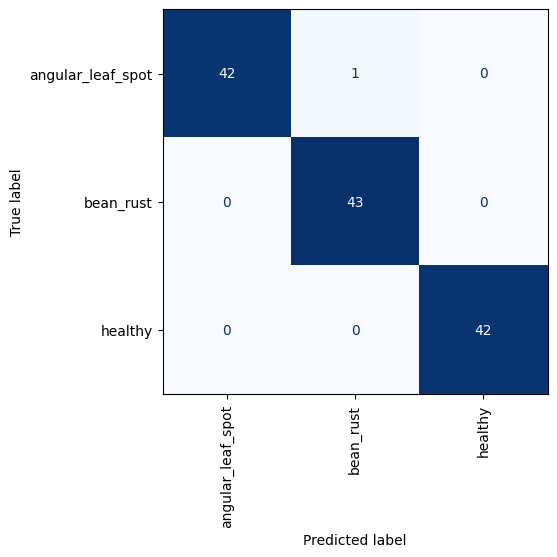

In [18]:
# Plot confusion matrix with improved formatting
conf = confusion_matrix(y_test_true, y_test_pred_classes)
disp = ConfusionMatrixDisplay(conf, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=False)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


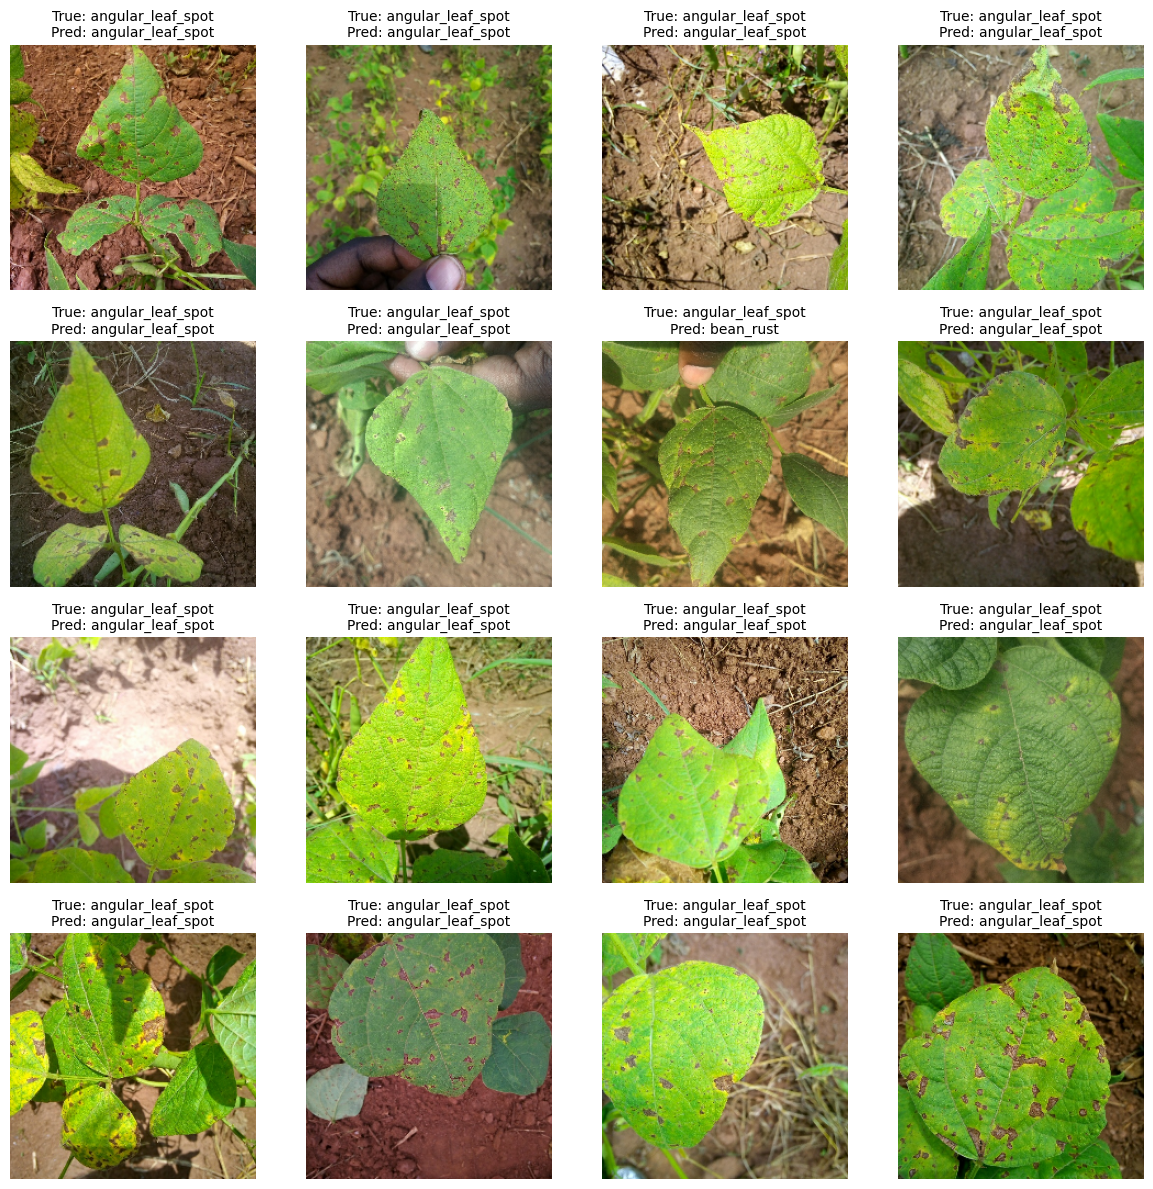

In [19]:
# Test veri setinden bir parti alıyoruz
test_batch = next(iter(test_ds.take(1)))
test_images, test_labels = test_batch
test_images = test_images.numpy()
test_labels = test_labels.numpy()

# Tahminlerimizi yapıyoruz
y_test_pred = model.predict(test_images)
y_test_pred_classes = np.argmax(y_test_pred, axis=-1)
y_test_true_classes = np.argmax(test_labels, axis=-1)

# Görselleştirme
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(test_images):
        img = test_images[i].astype("uint8")
        true_label = class_names[y_test_true_classes[i]]
        pred_label = class_names[y_test_pred_classes[i]]
        
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()